# Example Notebook for Correcting and loading FastCCD Images

This example reads data from the FastCCD and corrects and rotates the images. Included are some
example of widgets to interact with the data

## Getting Started

Load the ``databroker`` moudle, ``csxtools`` and various other dependencies

In [1]:
import numpy as np
from databroker import DataBroker, get_table
from csxtools.utils import get_fastccd_images, get_images_to_4D
from csxtools.ipynb import image_stack_to_movie, show_image_stack
%matplotlib inline
from matplotlib import pyplot as plt

Set the logger level to info to see logging output

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [3]:
from filestore.handlers import HDF5DatasetSliceHandler, AreaDetectorHDF5Handler
from pims import FramesSequence, Frame

class ImageCube(FramesSequence):
    "One of these represents the data from an event: (num_images x w x h)"
    def __init__(self, hdf5_dataset, start, stop):
        # `start` and `stop` are the limits of this cube; i indexes within the cube
        self._start = start
        self._stop = stop
        self._dataset = hdf5_dataset
        
        # work around inconsistent naming choices in databroker's Image object
        self.dtype = self.pixel_type
        self.shape = self.frame_shape
        
    def get_frame(self, i):
        return Frame(self._dataset[self._start + i], frame_no=i)
    
    def __len__(self):
        return list(self._dataset.shape)[0]
    
    @property
    def pixel_type(self):
        return self._dataset.dtype
    
    @property
    def frame_shape(self):
        return self._dataset.shape
    
# Customize HDF5DatasetSliceHandler to return a PIMS object,
# not a numpy array.

class LazyHDF5DatasetSliceHandler(HDF5DatasetSliceHandler):
    """
    Handler for data stored in one Dataset of an HDF5 file.
    
    Parameters
    ----------
    filename : string
        path to HDF5 file
    key : string
        key of the single HDF5 Dataset used by this Handler
    frame_per_point : integer, optional
        number of frames to return as one datum, default 1
    """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._pims_objects = {}
        
    def __call__(self, point_number):
        # Don't read out the dataset until it is requested for the first time.
        if not self._dataset:
            self._dataset = self._file[self._key]
        if not point_number in self._pims_objects:
            start, stop = point_number * self._fpp, (point_number + 1) * self._fpp
            self._pims_objects[point_number] = ImageCube(self._dataset, start, stop)
        return self._pims_objects[point_number]

# Inject the code specific to area detector (e.g., the layout of the HDF5 file)
# via subclassing AreaDetectorHDF5Handler.

class LazyAreaDetectorHDF5Handler(AreaDetectorHDF5Handler, LazyHDF5DatasetSliceHandler):
    pass

In [4]:
from databroker import DataBroker as db, get_images, get_events
from filestore.api import deregister_handler, register_handler

# Replace the default handler with the lazy one.
# Do this at the beginning of every session.
deregister_handler('AD_HDF5')
register_handler('AD_HDF5', LazyAreaDetectorHDF5Handler)

## Get the data headers from the DataBroker!

In [5]:
bgnd = DataBroker['ce5042b7-00ae-49ca-9b11-b10c5661aaaa'] #[52440]

INFO:databroker.databroker:Interpreting key = ce5042b7-00ae-49ca-9b11-b10c5661aaaa as a str


In [6]:
data = DataBroker['b2596f8e-d220-4aea-8a55-8ccb17cbdacc'] #[52436]

INFO:databroker.databroker:Interpreting key = b2596f8e-d220-4aea-8a55-8ccb17cbdacc as a str


## Correct the FastCCD Images

Now correct the CCD images, using only a single background image. 

In the future this should be taken from the metadata associated with the data, or from the darkfield entry

First lets just look at the background stack as a "lightfield"

In [7]:
images = get_fastccd_images(data, (bgnd, None, None), tag='fccd_image_lightfield')

INFO:csxtools.utils:Took 0.123 seconds to read data using get_images
INFO:csxtools.utils:Image conversion took 53.028 seconds
INFO:csxtools.fastccd.images:Correcting image stack of shape (1, 1200, 960, 960)
INFO:csxtools.fastccd.images:Not correcting for darkfield. No input.
INFO:csxtools.fastccd.images:Not correcting for flatfield. No input.
INFO:csxtools.fastccd.images:Corrected image stack in 0.679 seconds
INFO:csxtools.utils:Mean of image stack took 5.699 seconds
INFO:csxtools.utils:Computed dark images in 59.602 seconds
INFO:csxtools.utils:Took 0.072 seconds to read data using get_images


## Format of returned object

The returned `images` object is a 4D stack of images of shape `(N, M, y, x)` where `N` is the number of events. This is - for example - the number of data points in a scan. `M` is the number of images collected at each point, while `y` and `x` are the size of the CCD chip.

As the data was collected as a single `ct()`, there is only one event. Lets select that. 

In [8]:
stack = images[0]

INFO:csxtools.fastccd.images:Correcting image stack of shape (1200, 960, 960)
INFO:csxtools.fastccd.images:Not correcting for flatfield. No input.
INFO:csxtools.fastccd.images:Corrected image stack in 0.765 seconds


We can use this as a PIMS object, or we could convert it to a image stack using the `get_images_to_4D()` function

In [9]:
arr = get_images_to_4D(stack)
arr.shape

(1200, 960, 960)

In [10]:
type(arr)

numpy.ndarray

In [11]:
arr[0] # The first image, corrected

array([[ 17.7734375 ,  27.36669922,  19.68994141, ...,  15.08422852,
         21.79077148,  16.77246094],
       [ 14.80004883,  16.87573242,  29.84326172, ...,  12.10839844,
         11.42260742,  10.31494141],
       [ 19.51660156,  15.24658203,  12.3425293 , ...,  13.12011719,
         28.76489258,  16.87329102],
       ..., 
       [ 18.60742188,  17.8984375 ,   3.64916992, ...,  19.54492188,
         15.02075195,  13.25585938],
       [  5.88085938,  14.5       ,   5.63842773, ...,  17.73339844,
         18.64990234,  13.80078125],
       [  8.1484375 ,  19.43579102,   4.26928711, ...,  23.22094727,
         21.28491211,   7.49414062]], dtype=float32)

## Now lets do an interactive plotting widget!

We can, however use the pims object in most functions to look at the data. There are a couple of nice interactive objects which can be used to look at image stacks.

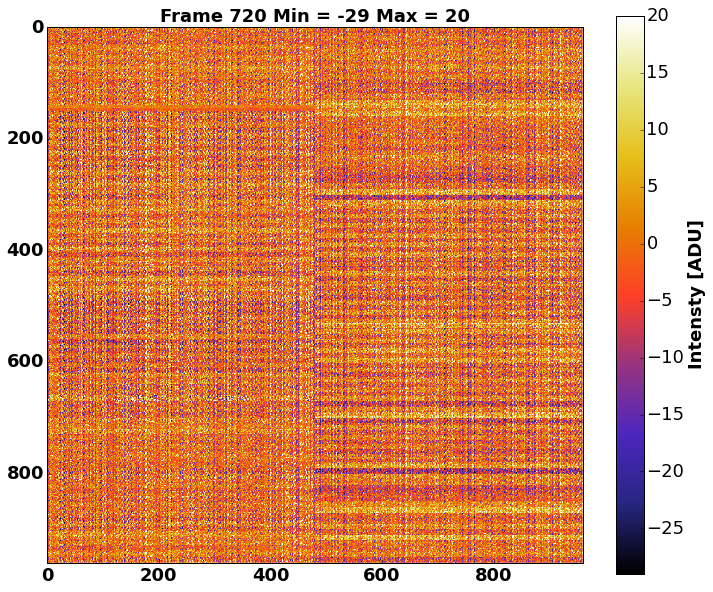

In [12]:
show_image_stack(stack, (-100, 100))

## And lets do a movie of the stack of images
This produces an HTML5 movie which can be viewed in most browsers

In [13]:
image_stack_to_movie(images[0], frames=10, figsize=(12, 10), vmin=-20, vmax=20)

INFO:csxtools.fastccd.images:Correcting image stack of shape (1200, 960, 960)
INFO:csxtools.fastccd.images:Not correcting for flatfield. No input.
INFO:csxtools.fastccd.images:Corrected image stack in 0.792 seconds


What version are we running?

In [14]:
import csxtools
csxtools.__version__

'0.1.1+12.g7c18bb3'